## 0. Setup & Configuration
Responsible for imports, paths, session auth, and environment loading.

In [18]:
# Install deps if needed (uncomment for first run)
# %pip install -r requirements.txt
import os
import re
from pathlib import Path
import pandas as pd
import requests
from tqdm import tqdm
from rapidfuzz import fuzz
import matplotlib.pyplot as plt
import unicodedata, string
from urllib.parse import quote
from dotenv import load_dotenv

DATA_PATH = Path("Company.csv")
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Secrets
load_dotenv()
COMPANIES_HOUSE_API_KEY = os.getenv("COMPANIES_HOUSE_API_KEY", "")
BASE_URL = "https://api.company-information.service.gov.uk"

# Session
session = requests.Session()
if COMPANIES_HOUSE_API_KEY:
    session.auth = (COMPANIES_HOUSE_API_KEY, "")

print("API key present:", bool(COMPANIES_HOUSE_API_KEY))
print("Data path exists:", DATA_PATH.exists())

API key present: True
Data path exists: True


## 1. Data Collection
Load the provided `Company.csv` exactly as-is.

In [19]:
# Load input CSV
assert DATA_PATH.exists(), "Company.csv"
df_raw = pd.read_csv(DATA_PATH)
print("Rows:", len(df_raw))
display(df_raw.head())

Rows: 306


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19-12-2024,NaN
1,BULLDOG LIMITED,9043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-05-2025,16-05-2024
2,BULLDOG MUSHROOMS LTD,8465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11-04-2025,28-03-2024
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,1652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-2025,18-12-2023
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,4667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08-02-2022,25-01-2021


## 2. Profiling
Lightweight schema/quality profile to understand columns, nulls, and uniqueness. These checks are **non-destructive**.

In [20]:
# Simple schema/quality profile
def profile_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        s = df[col]
        rows.append({
            "column": col,
            "dtype": s.dtype.name,
            "nulls": int(s.isna().sum()),
            "non_null": int(s.notna().sum()),
            "unique": int(s.nunique(dropna=True)),
            "sample_values": list(s.dropna().astype(str).head(3))
        })
    return pd.DataFrame(rows)

profile = profile_dataframe(df_raw)
display(profile)

null_pct = df_raw.isna().mean().sort_values(ascending=False)
display(null_pct.to_frame("null_pct"))


,column,dtype,nulls,non_null,unique,sample_values
0,CompanyName,object,0,306,299,"[BULLDOG MINI SKIPS LTD, BULLDOG LIMITED, BULL..."
1,CompanyNumber,object,20,286,270,"[15330909, 9043007, 8465312]"
2,RegAddress.CareOf,object,304,2,2,"[GW COX & CO, SINCLAIR]"
3,RegAddress.POBox,float64,302,4,1,"[4385.0, 4385.0, 4385.0]"
4,RegAddress.AddressLine1,object,5,301,258,"[YARD 1, ARNOCK BUNGALOW, FORESTERS COTTAGE, C..."
5,RegAddress.AddressLine2,object,119,187,152,"[SOUTHEND ARTERIAL ROAD, STONEY HEATH, NINE EL..."
6,RegAddress.PostTown,object,57,249,162,"[BRENTWOOD, BASINGSTOKE, SURREY]"
7,RegAddress.County,object,199,107,47,"[HAMPSHIRE, SUFFOLK, shropshire]"
8,RegAddress.Country,object,64,242,11,"[UNITED KINGDOM, ENGLAND, ENGLAND]"
9,RegAddress.PostCode,object,7,299,237,"[CM13 3TB, RG26 5SW, SW8 5JJ]"


,null_pct
DissolutionDate,1.000000
PreviousName_9.CONDATE,1.000000
PreviousName_9.CompanyName,1.000000
PreviousName_10.CONDATE,1.000000
PreviousName_6.CompanyName,1.000000
PreviousName_3.CONDATE,1.000000
PreviousName_3.CompanyName,1.000000
PreviousName_8.CONDATE,1.000000
PreviousName_4.CONDATE,1.000000
PreviousName_5.CONDATE,1.000000


## 3. Cleansing (Non-destructive normalization)
Create derived, normalized fields while preserving originals. Goals:

- Handle whitespace, casing, punctuation, and accents in names
- Normalize UK postcodes to a consistent format
- Normalize emails to lowercase
- Build a `block_key` for within-block fuzzy deduplication

In [21]:
import re, unicodedata, string

COMPANY_SUFFIXES = {
    "LTD": "LIMITED", "LTD.": "LIMITED",
    "LIMITED": "LIMITED", "PLC": "PLC",
    "LLP": "LLP", "L.L.P": "LLP"
}

def normalize_whitespace(s):
    if not isinstance(s, str):
        return ""
    s = s.replace("\n", " ").replace("\r", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def strip_punct(s):
    return "".join(ch for ch in s if ch not in set(string.punctuation))

def normalize_company_name(s):
    s = normalize_whitespace(s).upper()
    # remove accents
    s = unicodedata.normalize("NFKD", s)
    s = "".join([c for c in s if not unicodedata.combining(c)])
    # Normalize common suffixes
    toks = s.split(" ")
    toks = [COMPANY_SUFFIXES.get(t, t) for t in toks]
    s = " ".join(toks)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_postcode(s):
    s = normalize_whitespace(str(s))
    s = s.upper().replace(" ", "")
    if len(s) > 3:
        s = s[:-3] + " " + s[-3:]
    return s.strip()

def normalize_email(s):
    s = normalize_whitespace(str(s)).lower()
    return s

def cleanse(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # company name
    name_col = next((c for c in out.columns if "company" in c.lower() and "name" in c.lower()), None)
    if name_col is None:
        out["company_name_norm"] = ""
    else:
        out["company_name_norm"] = out[name_col].astype(str).apply(normalize_company_name)

    # postcode
    postcode_col = next((c for c in out.columns if "postcode" in c.lower()), None)
    if postcode_col is None:
        out["postcode_norm"] = ""
    else:
        out["postcode_norm"] = out[postcode_col].astype(str).apply(normalize_postcode)

    # email (optional)
    email_col = next((c for c in out.columns if "email" in c.lower()), None)
    if email_col is None:
        out["email_norm"] = ""
    else:
        out["email_norm"] = out[email_col].astype(str).apply(normalize_email)

    # block key
    out["block_key"] = out["company_name_norm"].str.replace(" ", "", regex=False) + "|" + out["postcode_norm"].fillna("")
    return out

df_clean = cleanse(df_raw)
display(df_clean.head())

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate,company_name_norm,postcode_norm,email_norm,block_key
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,...,NaN,NaN,NaN,NaN,19-12-2024,NaN,BULLDOG MINI SKIPS LIMITED,CM13 3TB,,BULLDOGMINISKIPSLIMITED|CM13 3TB
1,BULLDOG LIMITED,9043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,...,NaN,NaN,NaN,NaN,30-05-2025,16-05-2024,BULLDOG LIMITED,RG26 5SW,,BULLDOGLIMITED|RG26 5SW
2,BULLDOG MUSHROOMS LTD,8465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,...,NaN,NaN,NaN,NaN,11-04-2025,28-03-2024,BULLDOG MUSHROOMS LIMITED,SW8 5JJ,,BULLDOGMUSHROOMSLIMITED|SW8 5JJ
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,1652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,...,NaN,NaN,NaN,NaN,01-01-2025,18-12-2023,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,KT19 0ST,,BULLDOGMUSICALENTERTAINMENTSLIMITED|KT19 0ST
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,4667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,...,NaN,NaN,NaN,NaN,08-02-2022,25-01-2021,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,SO15 2RP,,BULLDOGNETWORK(BOURNEMOUTH)LIMITED|SO15 2RP


## 4. Deduplication
Two steps:

1. **Exact**: drop duplicates on normalized columns  
2. **Fuzzy within block**: cluster near-duplicates using `token_sort_ratio` and take a canonical record per cluster

In [22]:
# Exact dedup on normalized keys
dedup_cols = ["company_name_norm","postcode_norm","email_norm"]
dedup_cols = [c for c in dedup_cols if c in df_clean.columns]
before = len(df_clean)
df_dedup = df_clean.drop_duplicates(subset=dedup_cols, keep="first").copy()
print(f"Exact dedup removed {before - len(df_dedup)} rows")

# Fuzzy clustering within blocks
def fuzzy_cluster_block(block_df: pd.DataFrame, name_col="company_name_norm", threshold=95):
    taken = set()
    clusters = []
    names = block_df[name_col].tolist()
    idxs = block_df.index.tolist()
    for i, idx in enumerate(idxs):
        if idx in taken:
            continue
        base = names[i]
        cl = [idx]
        taken.add(idx)
        for j in range(i+1, len(idxs)):
            jdx = idxs[j]
            if jdx in taken:
                continue
            score = fuzz.token_sort_ratio(base, names[j])
            if score >= threshold:
                cl.append(jdx)
                taken.add(jdx)
        clusters.append(cl)
    return clusters

clusters = []
for key, block_df in df_dedup.groupby("block_key"):
    if len(block_df) == 1:
        clusters.append([block_df.index[0]])
    else:
        clusters.extend(fuzzy_cluster_block(block_df, threshold=93))

canonical_idx = [c[0] for c in clusters]
df_canonical = df_dedup.loc[canonical_idx].copy().reset_index(drop=True)
print("Canonical records:", len(df_canonical), "from", len(df_dedup))

# optional mapping
cluster_map = {}
for cid, cl in enumerate(clusters):
    for idx in cl:
        cluster_map[idx] = cid
df_dedup = df_dedup.copy()
df_dedup["cluster_id"] = df_dedup.index.map(cluster_map)
df_dedup.to_csv(OUTPUT_DIR / "dedup_clusters.csv", index=False)

Exact dedup removed 8 rows
Canonical records: 298 from 298


### Performance & rate limits
API calls dominate runtime. Expect variable latency and occasional 429s. The small retry/backoff in code keeps the run going without manual intervention.

## 5. Matching (Companies House) & Enrichment
**Rationale**: Local text similarity recovers probable matches. We then call Companies House to retrieve authoritative IDs and status.

In [24]:
# -----------------------------------
# Companies House search function
# -----------------------------------
def ch_search_company(query: str, items_per_page: int = 5, retries: int = 2, backoff: float = 1.5):
    if not COMPANIES_HOUSE_API_KEY:
        raise RuntimeError("Set COMPANIES_HOUSE_API_KEY in .env before calling Companies House API.")

    url = f"{BASE_URL}/search/companies?q={quote(query)}&items_per_page={items_per_page}"

    for attempt in range(retries + 1):
        try:
            r = session.get(url, timeout=20)
        except Exception as e:
            print(f" Request failed for '{query}': {e}")
            return {"error": True, "status_code": None}

        # Handle rate limits with retry backoff
        if r.status_code == 429 and attempt < retries:
            time.sleep(backoff * (attempt + 1))
            continue

        # Status code error → mark as failed
        if r.status_code >= 400:
            return {"error": True, "status_code": r.status_code}

        try:
            return r.json()
        except Exception:
            return {"error": True, "status_code": r.status_code}

    return {"error": True, "status_code": 429}


# -----------------------------------
#  fuzzy match selector
# -----------------------------------
def best_match_for_name(name: str):
    data = ch_search_company(name, items_per_page=10)

    # FIX 1: Skip if API returned error or malformed response
    if not isinstance(data, dict) or data.get("error"):
        return None

    items = data.get("items", [])
    if not items:
        return None

    # Compute fuzzy match scores for all candidates
    candidates = []
    for it in items:
        reg_name = it.get("title") or it.get("company_name") or ""
        score = fuzz.token_set_ratio(name.upper(), reg_name.upper())
        candidates.append((score, it))

    if not candidates:
        return None

    # Sort by descending match score
    candidates.sort(reverse=True, key=lambda x: x[0])
    best_score, best_item = candidates[0]

    #  FIX 2: Safely flatten keys to avoid missing-field errors
    out = {
        "ch_best_title": best_item.get("title") or best_item.get("company_name"),
        "ch_best_company_number": best_item.get("company_number", None),
        "ch_best_company_status": best_item.get("company_status", None),
        "ch_best_address_snippet": best_item.get("address_snippet", None),
        "ch_best_date_of_creation": best_item.get("date_of_creation", None),
        "ch_best_score": best_score,
    }
    return out


# -----------------------------------
# Enrichment pipeline
# -----------------------------------
enrich_cols = [
    "ch_best_title",
    "ch_best_company_number",
    "ch_best_company_status",
    "ch_best_address_snippet",
    "ch_best_date_of_creation",
    "ch_best_score",
]

matches = []
for name in tqdm(df_canonical["company_name_norm"], desc="Matching Companies House"):
    try:
        m = best_match_for_name(name)
    except Exception as e:
        print(f"⚠️ Error for '{name}': {e}")
        m = None
    matches.append(m)

# FIX 3: Handle missing keys when normalizing
if any(matches):
    df_matches = pd.json_normalize(matches)
    for col in enrich_cols:
        if col not in df_matches.columns:
            df_matches[col] = None
    df_matches = df_matches[enrich_cols]
else:
    df_matches = pd.DataFrame(columns=enrich_cols)

# Merge canonical + enriched
df_enriched = pd.concat(
    [df_canonical.reset_index(drop=True), df_matches.reset_index(drop=True)],
    axis=1
)

display(df_enriched.head())

# Save to output folder
df_enriched.to_csv(OUTPUT_DIR / "enriched_companies.csv", index=False)
print(f"\n Enriched dataset saved to: {OUTPUT_DIR / 'enriched_companies.csv'}")

Matching Companies House:   0%|          | 0/298 [00:00<?, ?it/s]

Matching Companies House: 100%|██████████| 298/298 [00:29<00:00,  9.98it/s]


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,company_name_norm,postcode_norm,email_norm,block_key,ch_best_title,ch_best_company_number,ch_best_company_status,ch_best_address_snippet,ch_best_date_of_creation,ch_best_score
0,AIRLINE 4 DIALOGUE LTD,5883574,NaN,NaN,6 NORTH STREET,NaN,OUNDLE,PETERBOROUGH,ENGLAND,PE8 4AL,...,AIRLINE 4 DIALOGUE LIMITED,PE8 4AL,,AIRLINE4DIALOGUELIMITED|PE8 4AL,AIRLINES 4 DIALOGUE LIMITED,05882574,active,"The Old Town Hall Market Place, Oundle, Peterb...",2006-07-20,98.113208
1,AIRLINE BAGAGE LTD,15139570,NaN,NaN,39 SUTTON SQUARE,NaN,HOUNSLOW,NaN,UK,TW5 0JB,...,AIRLINE BAGAGE LIMITED,TW5 0JB,,AIRLINEBAGAGELIMITED|TW5 0JB,AIRLINES BAGAGE LTD,15139570,dissolved,"29 Sutton Square, Hounslow, United Kingdom, TW...",2023-09-14,87.804878
2,AIRLINE GLOBAL SOLUTIONS LTD,13776613,NaN,NaN,UNIT 8 THE COURTYARD GAULBY LANE,STOUGHTON,LEICESTERSHIRE,NaN,ENGLAND,LE3 3FL,...,AIRLINE GLOBAL SOLUTIONS LIMITED,LE3 3FL,,AIRLINEGLOBALSOLUTIONSLIMITED|LE3 3FL,AIRLINES GLOBAL SOLUTIONS LIMITED,12776613,active,"Unit 8 The Courtyard Gaulby Lane, Stoughton, L...",2020-07-29,98.461538
3,AIRLINE MARKET LTD,10899619,NaN,NaN,11 THOMAS GEORGE WAY,NaN,BIRMINGHAM,NaN,UK,B19 3NE,...,AIRLINE MARKET LIMITED,B19 3NE,,AIRLINEMARKETLIMITED|B19 3NE,AIRLINES MARKET LIMITED,10899619,active,"11 Thomas George Way, Birmingham, United Kingd...",2017-08-04,97.777778
4,AIRLINEN LTD,10141677,NaN,NaN,"VIDEK HOUSE, BUILDING 2",KINGSBURY ROAD,NaN,NaN,ENGLAND,NW9 8RW,...,AIRLINEN LIMITED,NW9 8RW,,AIRLINENLIMITED|NW9 8RW,AIRLINEN LTD,10141677,active,"Videk House, Building 2, Kingsbury Road, Londo...",2016-04-22,85.714286



 Enriched dataset saved to: outputs\enriched_companies.csv


## 6. Reporting & Visualisation
KPIs and diagnostic charts.

### What to read in the results
- Match coverage and enriched count show how much the pipeline validated.
- Score histogram and status distribution help spot anomalies and input drift.
- Confidence bands (high/mid/low) guide what to accept vs send to review.


,input_rows,after_exact_dedup,canonical_records,enriched_records,match_rate_pct
0,306,298,298,297,99.66


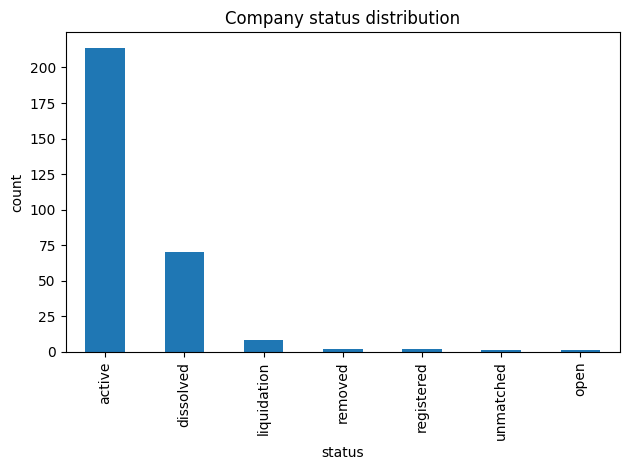

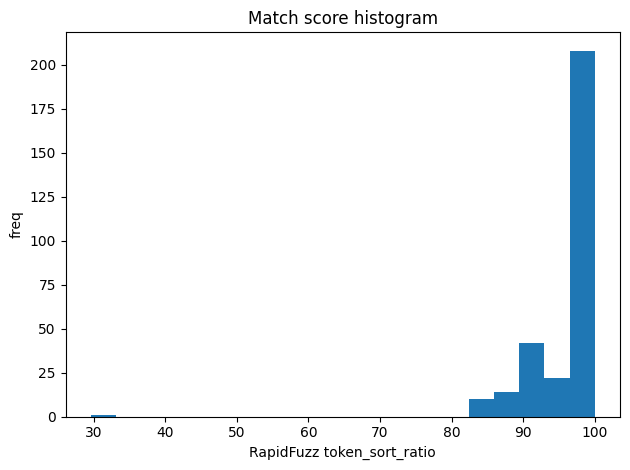

In [25]:
# KPIs / coverage
kpis = {
    "input_rows": int(len(df_raw)),
    "after_exact_dedup": int(len(df_dedup)),
    "canonical_records": int(len(df_canonical)),
}

if "ch_best_company_number" in df_enriched.columns:
    kpis["enriched_records"] = int(df_enriched["ch_best_company_number"].notna().sum())
    kpis["match_rate_pct"] = round(100.0 * df_enriched["ch_best_company_number"].notna().mean(), 2)
else:
    kpis["enriched_records"] = 0
    kpis["match_rate_pct"] = 0.0

display(pd.DataFrame([kpis]))

# Status distribution
if "ch_best_company_status" in df_enriched.columns:
    status_counts = df_enriched["ch_best_company_status"].fillna("unmatched").value_counts().sort_values(ascending=False)
    plt.figure()
    status_counts.plot(kind="bar", title="Company status distribution")
    plt.xlabel("status"); plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Score histogram
if "ch_best_score" in df_enriched.columns:
    plt.figure()
    df_enriched["ch_best_score"].dropna().astype(float).plot(kind="hist", bins=20, title="Match score histogram")
    plt.xlabel("RapidFuzz token_sort_ratio"); plt.ylabel("freq")
    plt.tight_layout()
    plt.show()


### Evaluation (Proxy Metrics)
These metrics do not require labeled ground truth but still provide a quality signal.

In [ ]:
# These metrics do not require ground truth and do not change your logic.

eval_rows = []

if "ch_best_score" in df_enriched.columns:
    scores = df_enriched["ch_best_score"].fillna(0).astype(float)
    eval_rows.append({"metric":"avg_score", "value": float(scores.mean())})
    eval_rows.append({"metric":"p90_score", "value": float(scores.quantile(0.9))})
    eval_rows.append({"metric":"high_confidence_rate_95+", "value": float((scores>=95).mean())})
    eval_rows.append({"metric":"mid_confidence_rate_85_95", "value": float(((scores>=85)&(scores<95)).mean())})
    eval_rows.append({"metric":"low_confidence_rate_<85", "value": float((scores<85).mean())})

# Ambiguity proxy: name mismatch length for high scores
if set(["company_name_norm","ch_best_title","ch_best_score"]).issubset(df_enriched.columns):
    def token_set(s):
        return set(str(s).upper().split())
    def jaccard(a,b):
        a,b=token_set(a),token_set(b)
        if not a and not b: return 1.0
        return len(a&b)/max(1,len(a|b))
    mask = df_enriched["ch_best_score"].fillna(0).astype(float)>=90
    jacc = df_enriched.loc[mask].apply(lambda r: jaccard(r["company_name_norm"], r["ch_best_title"]), axis=1)
    eval_rows.append({"metric":"high_score_avg_name_jaccard", "value": float(jacc.mean())})

eval_df = pd.DataFrame(eval_rows)
display(eval_df)

## 7. Outputs
Exports are written to `./outputs/`.

In [26]:
# Save final outputs
profile = profile_dataframe(df_raw)
(OUTPUT_DIR / "profile.csv").write_text("")
profile.to_csv(OUTPUT_DIR / "profile.csv", index=False)

df_enriched.to_parquet(OUTPUT_DIR / "enriched_companies.parquet", index=False)
df_enriched.to_csv(OUTPUT_DIR / "enriched_companies.csv", index=False)
print("Files written to:", OUTPUT_DIR.resolve())
list(OUTPUT_DIR.glob("*"))

Files written to: C:\advancedcompanyprofiling\Advanced_Company_MDM\outputs


[WindowsPath('outputs/dedup_clusters.csv'),
 WindowsPath('outputs/enriched_companies.csv'),
 WindowsPath('outputs/enriched_companies.parquet'),
 WindowsPath('outputs/profile.csv')]